<a href="https://colab.research.google.com/github/raulbenitez/postgrau_IML_exploratory/blob/master/SHORT_pattern_recognition_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pattern Recognition in digital images

This notebook will guide you through three different approaches do recognize patterns in digital images:

1. Object recognition using regional properties: We first segment the objects, extract some attributes (shape, size, etc) and train a classifier that recognizes the different types of objects. 

2. Face recognition using PCA features: USe PCA in order to extract meaningful features that allow classifying images to recognize faces.

## 1. Object recognition using regional properties:

Let's start with an image with circles and triangles of different sizes:

### 1. Generation of the sample image:

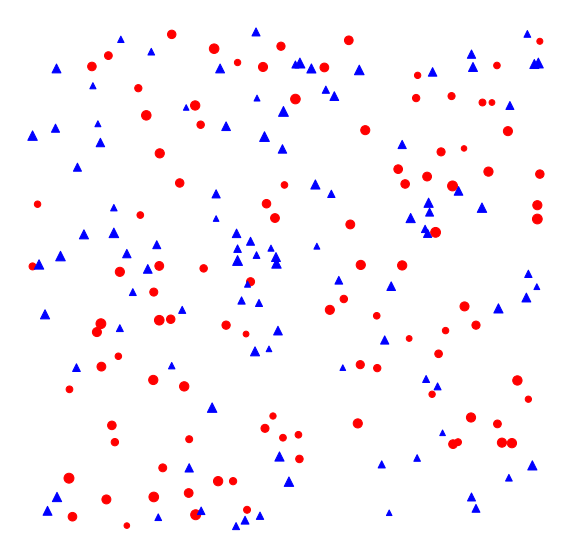

In [ ]:
import numpy as np 
np.random.seed(13)

import matplotlib.pyplot as plt 
Isize = 1024
N = 100

X = np.random.randint(Isize, size=(2,2*N)) # random placement of objects

fig = plt.figure(figsize=(10,10))
symsizes1 = np.random.randint(30,100,size=(1,N))
symsizes2 = np.random.randint(30,100,size=(1,N))
plt.scatter(X[0,0:N], X[1,0:N], s=symsizes1, c='r',edgecolor="red",marker = 'o')
plt.scatter(X[0,N:2*N], X[1,N:2*N], s=symsizes2, c='b',edgecolor="blue",marker = '^')
plt.axis('off')
plt.savefig('Patterns.png',dpi=600, facecolor='w',optimize=False,bbox_inches='tight')
plt.show()

### Reading the image:

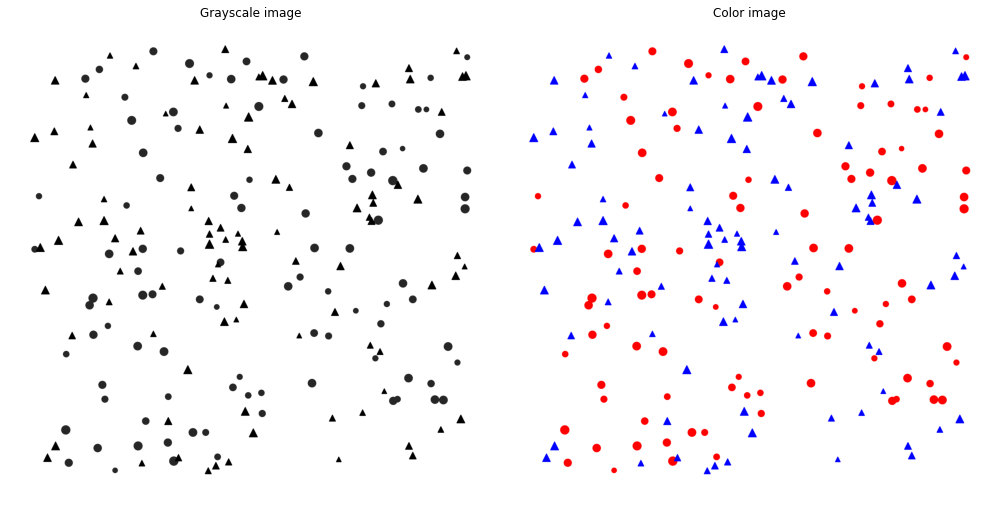

In [ ]:
import matplotlib.pyplot as plt
from skimage import io

from skimage import data
from skimage.filters import threshold_otsu
from skimage.measure import label

I = io.imread('Patterns.png',as_gray=True) # read image as grayscale (no color information)
IC = io.imread('Patterns.png') # read image as color (to define object class labels: triangle, circle)

fig, axes = plt.subplots(1,2,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(I,cmap=plt.cm.gray)
ax[0].set_title('Grayscale image') 
ax[1].imshow(IC,cmap=plt.cm.jet)
ax[1].set_title('Color image') # set figure title

ax[0].set_axis_off()
ax[1].set_axis_off()
plt.tight_layout()
plt.show()

### 2. Segmentation and regional features:

We now segment and extract regional properties:

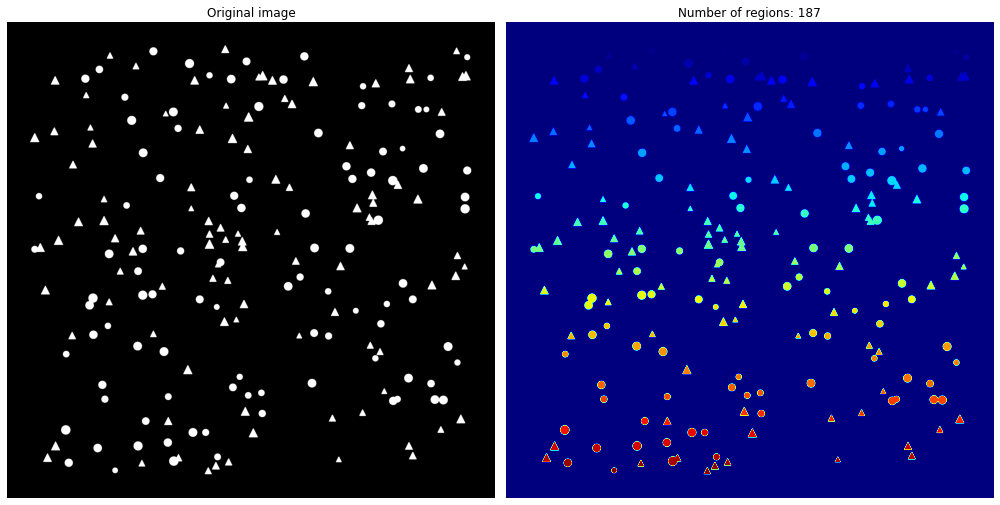

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
bw = np.logical_not(I==1)# Set regions white and background black
# label image regions:
label_image, nregions = label(bw,return_num=True)

# Segmentation figure:
fig, axes = plt.subplots(1,2,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(bw,cmap=plt.cm.gray)
ax[0].set_title('Original image') 
ax[1].imshow(label_image,cmap=plt.cm.jet)
ax[1].set_title('Number of regions: {}'.format(nregions)) # set figure title
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.tight_layout()
plt.show()

# Get regional properties:
from skimage.measure import regionprops
props = regionprops(label_image)

# Get relevant features (eccentricity and area, for instance)
features = np.zeros((nregions,2))
labels = np.zeros(nregions)
# Save class label of each object (1: triangle, 2:circle)
bw1 = np.array(IC[:,:,0]==0,dtype=np.uint8)
bw2 = np.array(IC[:,:,2]==0,dtype=np.uint8)
for i in range(0,nregions):
    features[i,0] = props[i].eccentricity
    features[i,1] = props[i].area
    labels[i] = bw1[np.int(props[i].centroid[0]),np.int(props[i].centroid[1])]+2*bw2[np.int(props[i].centroid[0]),np.int(props[i].centroid[1])]

### 3. Exploratory analysis of features:

A scatterplot of features shows that circles present low eccentricity whereas triangles present eccentricity around 0.5. There are some observations with higher eccentricities due to the overlaping cases between triangles and circles. 

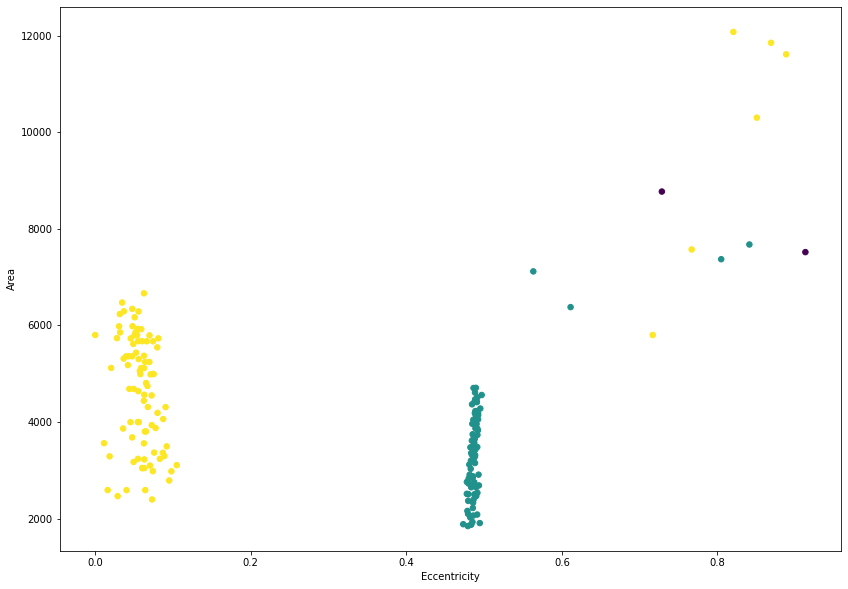

In [ ]:
fig = plt.figure(figsize=(14,10))
plt.scatter(features[:,0], features[:,1], s=30, c=labels,marker = 'o')
plt.xlabel('Eccentricity')
plt.ylabel('Area')
plt.show()

### 4. Fit Linear Discriminant Analysis (LDA):

Using object features (eccentricity, area) and object class (triangle, circle): Train classifier with the first NTRAIN observations. Fit a LDA classifier using object features (eccentricity, area) and object class (triangle, circle): Train classifier with the first NTRAIN observations:

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

NTRAIN = 50 # Train with NTRAIN objects

clf = LinearDiscriminantAnalysis()
clf.fit(features[0:NTRAIN,:], labels[0:NTRAIN])

LinearDiscriminantAnalysis()

Evaluate performance using Test dataset:

In [ ]:
labels_pred = clf.predict(features[NTRAIN+1:-1])
labels_true = labels[NTRAIN+1:-1]

In [ ]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(labels_true,labels_pred)
CM

array([[ 0,  2,  0],
       [ 0, 62,  0],
       [ 0,  6, 65]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(labels_true,labels_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.89      1.00      0.94        62
         2.0       1.00      0.92      0.96        71

    accuracy                           0.94       135
   macro avg       0.63      0.64      0.63       135
weighted avg       0.93      0.94      0.93       135



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 2. Face segmentation using PCA features:

We need a labelled face recognition database in which each image has a class label identifying the person to which it corresponds. In this case we are not classifying objects (regions of the image) but the whole image itself. We are going to use the Principal Component Analysis (PCA) of the pixels in the image as features of the whole image instead regional properties as in the previous example. PCA is a dimensionality reduction method that reduces the number of variables needed to describe the images (before PCA, we use as many variables as pixels in the image, after PCA we have a reduced number of variables that are a weighted linear combination of the original pixels in the image). 

Let's get started: 

### 1. Read images from dataset:

In this example we are going to use the image dataset 'Labelled Faces in the Wild' http://vis-www.cs.umass.edu/lfw/
that contains more than 13,000 images of faces collected from the web. Each face has been labeled with the name of the person pictured (famous people).

In [ ]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=1)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print('Width {} pixels'.format(w))
print('Height {} pixels'.format(h))

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

2022-05-02 14:13:23,770 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012


Automatically created module for IPython interactive environment


2022-05-02 14:13:24,762 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2022-05-02 14:13:25,701 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2022-05-02 14:13:26,849 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


Total dataset size:
n_samples: 1288
n_features: 11750
n_classes: 7
Width 94 pixels
Height 125 pixels


### 2. Feature Extraction: PCA features (eigenfaces)

In [ ]:
from sklearn.decomposition import PCA

n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("PCA projection of the images")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Extracting the top 150 eigenfaces from 966 faces
PCA projection of the images


### 3. Fit different unsupervised classifiers:

### Support Vector Machine (SVM):

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

print("Fitting the classifier to the training set")
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
svm = svm.fit(X_train_pca, y_train)

Fitting the classifier to the training set


Performance Evaluation (using test images):

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Predicting people's names on the test set")
y_pred_svm = svm.predict(X_test_pca)
print(classification_report(y_test, y_pred_svm, target_names=target_names))
print(confusion_matrix(y_test, y_pred_svm, labels=range(n_classes)))

Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.46      0.57        13
     Colin Powell       0.80      0.87      0.83        60
  Donald Rumsfeld       0.85      0.63      0.72        27
    George W Bush       0.85      0.97      0.91       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       0.89      0.53      0.67        15
       Tony Blair       0.94      0.83      0.88        36

         accuracy                           0.85       322
        macro avg       0.86      0.73      0.78       322
     weighted avg       0.86      0.85      0.85       322

[[  6   2   1   4   0   0   0]
 [  1  52   1   5   0   1   0]
 [  1   1  17   8   0   0   0]
 [  0   4   0 142   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   4   0   1   1   8   1]
 [  0   1   1   4   0   0  30]]


### Linear Discriminant Analysis (LDA):

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda = lda.fit(X_train_pca, y_train)
y_pred_lda = lda.predict(X_test_pca)
print(classification_report(y_test, y_pred_lda, target_names=target_names))
print(confusion_matrix(y_test, y_pred_lda, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Ariel Sharon       0.82      0.69      0.75        13
     Colin Powell       0.79      0.90      0.84        60
  Donald Rumsfeld       0.74      0.74      0.74        27
    George W Bush       0.92      0.92      0.92       146
Gerhard Schroeder       0.81      0.84      0.82        25
      Hugo Chavez       0.90      0.60      0.72        15
       Tony Blair       0.82      0.78      0.80        36

         accuracy                           0.86       322
        macro avg       0.83      0.78      0.80       322
     weighted avg       0.86      0.86      0.86       322

[[  9   2   2   0   0   0   0]
 [  1  54   1   2   0   1   1]
 [  1   2  20   3   0   0   1]
 [  0   6   3 135   1   0   1]
 [  0   1   0   2  21   0   1]
 [  0   1   0   2   1   9   2]
 [  0   2   1   2   3   0  28]]


### Decision Trees:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt = dt.fit(X_train_pca, y_train)
y_pred_dt = dt.predict(X_test_pca)
print(classification_report(y_test, y_pred_dt, target_names=target_names))
print(confusion_matrix(y_test, y_pred_dt, labels=range(n_classes)))


                   precision    recall  f1-score   support

     Ariel Sharon       0.11      0.15      0.13        13
     Colin Powell       0.42      0.42      0.42        60
  Donald Rumsfeld       0.12      0.19      0.15        27
    George W Bush       0.68      0.56      0.61       146
Gerhard Schroeder       0.20      0.20      0.20        25
      Hugo Chavez       0.11      0.13      0.12        15
       Tony Blair       0.15      0.17      0.16        36

         accuracy                           0.39       322
        macro avg       0.26      0.26      0.26       322
     weighted avg       0.44      0.39      0.41       322

[[ 2  2  3  3  2  0  1]
 [ 5 25  3 16  1  1  9]
 [ 2  5  5  7  4  1  3]
 [ 7 12 20 82  4  7 14]
 [ 1  3  6  3  5  5  2]
 [ 0  5  0  3  1  2  4]
 [ 1  8  4  7  8  2  6]]


### Artificial Neural Networks (ANNs):

In [ ]:
from sklearn.neural_network import MLPClassifier
ann = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(50,), random_state=1)
ann.fit(X_train_pca, y_train)
y_pred_ann = ann.predict(X_test_pca)
print(classification_report(y_test, y_pred_ann, target_names=target_names))
print(confusion_matrix(y_test, y_pred_ann, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.46      0.57        13
     Colin Powell       0.78      0.85      0.82        60
  Donald Rumsfeld       0.63      0.81      0.71        27
    George W Bush       0.90      0.84      0.87       146
Gerhard Schroeder       0.69      0.72      0.71        25
      Hugo Chavez       0.56      0.60      0.58        15
       Tony Blair       0.78      0.78      0.78        36

         accuracy                           0.80       322
        macro avg       0.73      0.72      0.72       322
     weighted avg       0.81      0.80      0.80       322

[[  6   2   3   2   0   0   0]
 [  1  51   2   3   0   1   2]
 [  0   2  22   2   0   0   1]
 [  0   5   6 123   5   4   3]
 [  0   2   0   2  18   2   1]
 [  1   2   0   0   2   9   1]
 [  0   1   2   4   1   0  28]]
